## Import the neeeded  modules and vectors

In [3]:
# from core import readfiles
import numpy as np
import os
import multiprocessing as mul
import matplotlib.pyplot as plt
from numba import jit, njit, prange, set_num_threads, vectorize, guvectorize, cuda
from tqdm import tqdm
from core.signal_bag import *
from core.stacking_analysis import *
from core.req_vectors import *
import pickle
import scipy.stats as st
import scipy.interpolate as interp
# import torch
# from core import weights

## concatenate the HESS and LHAASO vecrtors

In [4]:
gammaraysrc1ra=np.concatenate([lhsaao1ra, hess_ra], 0)
gammaraysrc1dec=np.concatenate([lhsaao1dec, hess_dec], 0)
gammaraysrc2ra=np.concatenate([lhsaao2ra, hess_ra], 0)
gammaraysrc2dec=np.concatenate([lhsaao2dec, hess_dec], 0)

## normalize the  flux

In [5]:
lhsaao1fnu_nor=lhsaao1fnu/np.sum(lhsaao1fnu)
lhsaao2fnu_nor=lhsaao2fnu/np.sum(lhsaao2fnu)
hessfnu=np.asfarray([float(i) for i in hessdata['Flux \xa0(max)\xa0[C.U.]'].values], dtype=str)



## remove the nan values in HESS flux 

In [6]:

nan_col = np.count_nonzero(hessfnu!= hessfnu)
if nan_col != 0: 
    not_nan = hessfnu[hessfnu == hessfnu]  
    hessfnu[np.isnan(hessfnu)] = np.mean(not_nan) 
print(hessfnu)

[0.25       0.19       0.09       0.66       0.05       0.02
 0.25       0.06       0.17       0.08       0.132      0.12
 0.06       0.24       0.07       0.018      0.05       0.15
 0.025      0.2        0.17       0.07       1.1        0.02
 0.02       0.03       0.75       0.02       3.         1.
 0.07       0.06       0.035      0.13       0.16       0.16
 0.016      0.14       0.12       0.11       0.1        0.013
 0.17       0.08       0.013      0.02       0.015      0.03
 0.03       0.03       0.03       0.018      0.13914024 0.13914024
 0.013      0.02       0.13       0.047      0.07       0.01
 0.003      0.17       0.13914024 0.02       0.008      0.009
 0.004      0.13914024 0.13914024 0.025      0.04       0.014
 0.02       0.04       0.0065     0.015      0.006      0.01
 0.018      0.13914024 0.015      0.01       0.13914024 0.007
 0.04       0.13914024 0.005      0.006      0.13914024 0.007
 0.006      0.13914024 0.13914024 0.13914024 0.13914024]


### normalize the HESS flux

In [8]:
hessnu_nor=hessfnu/np.sum(hessfnu)
print(hessnu_nor)

[0.01891314 0.01437399 0.00680873 0.04993069 0.00378263 0.00151305
 0.01891314 0.00453915 0.01286094 0.0060522  0.00998614 0.00907831
 0.00453915 0.01815661 0.00529568 0.00136175 0.00378263 0.01134788
 0.00189131 0.01513051 0.01286094 0.00529568 0.08321782 0.00151305
 0.00151305 0.00226958 0.05673942 0.00151305 0.22695768 0.07565256
 0.00529568 0.00453915 0.00264784 0.00983483 0.01210441 0.01210441
 0.00121044 0.01059136 0.00907831 0.00832178 0.00756526 0.00098348
 0.01286094 0.0060522  0.00098348 0.00151305 0.00113479 0.00226958
 0.00226958 0.00226958 0.00226958 0.00136175 0.01052632 0.01052632
 0.00098348 0.00151305 0.00983483 0.00355567 0.00529568 0.00075653
 0.00022696 0.01286094 0.01052632 0.00151305 0.00060522 0.00068087
 0.00030261 0.01052632 0.01052632 0.00189131 0.0030261  0.00105914
 0.00151305 0.0030261  0.00049174 0.00113479 0.00045392 0.00075653
 0.00136175 0.01052632 0.00113479 0.00075653 0.01052632 0.00052957
 0.0030261  0.01052632 0.00037826 0.00045392 0.01052632 0.0005

#### concentrate the HESS and LHAASO flux values

In [9]:
gammaraysrc1funor=np.concatenate([lhsaao1fnu_nor, hessnu_nor], 0)
gammaraysrc2funor=np.concatenate([lhsaao2fnu_nor, hessnu_nor], 0)
print(gammaraysrc2funor.shape)

(164,)


### some matplot configuration packages

In [10]:
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator, NullLocator
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator,LogitLocator,NullFormatter,FixedLocator)
import matplotlib

### read the machine configuration 

In [11]:
num_threads = int(mul.cpu_count()*0.9)
set_num_threads(num_threads)

In [12]:
len(gammaraysrc1ra)

170

## Energy bins for energy

In [13]:
# UNCOMMENT FOR LINEAR BINS
# all_enu = np.linspace(10**11.001, 10**18.999, 1000)
all_enu = e_nu_wall

# enus = 0.5*(all_enu[1:]+all_enu[:-1])
# UNCOMMENT FOR DENSER LOGARITHMIC BINS, optimal nbins is 1e6
enus = np.logspace(11.001, 18.999, int(1e6))
#print(e_nu_wall)
#print (np.where(enus>1.58489319e+11))


In [15]:
print(t_upt1,t_upt)

[32517530.86263724 30549103.12022511 27306301.28745167 28768007.01455351
 28682826.74322606 31358092.38190586 32027175.11202246 31566502.10216402
 30873121.15708538 35478964.62749199] [35318439.34329611 32497618.3151043  29902901.99932829 31745765.00015999
 32053797.00057632 33098838.99984006 34788962.99980783 33936928.00012794
 31302372.99945645 36107635.00003202]


In [16]:
enus_bin_indices = np.zeros(len(enus), dtype=np.int64)

for i in prange(len(enus)):
    enus_bin_indices[i] = np.digitize(enus[i], e_nu_wall) -1
print (enus_bin_indices)

[ 0  0  0 ... 39 39 39]


In [17]:
p2

69

In [18]:
msdec
print(dec_nu)

[-90.   -73.74 -66.93 -61.64 -57.14 -53.13 -49.46 -46.05 -42.84 -39.79
 -36.87 -34.06 -31.33 -28.69 -26.1  -23.58 -21.1  -18.66 -16.26 -13.89
 -11.54  -9.21  -6.89  -4.59  -2.29   0.     2.29   4.59   6.89   9.21
  11.54  13.89  16.26  18.66  21.1   23.58  26.1   28.69  31.33  34.06
  36.87  39.79  42.84  46.05  49.46  53.13  57.14  61.64  66.93  73.74
  90.  ]


In [19]:
ladec_bin_indices = np.zeros(len(gammaraysrc1ra), dtype=np.int64)
for i in prange(len(gammaraysrc1ra)):
    ladec_bin_indices[i] = np.digitize(gammaraysrc1dec[i], dec_nu) - 1
print(ladec_bin_indices)

[45 48 47 42 42 41 46 45 44 45 45 39 34 34 40 29 32 27 31 16 29 19 17 17
 18 19 19 20 20 21 22 22 22 23 24 24 24 25 25 26 27 27 29 27 30 31 31 31
 32 32 33 32 34 35 36 36 37 37 29 38 38 37 39 41 39 40 38 41 41 42 44 45
 46 46 46  5  5  6  9 12 13 15 17 19 21 21  6  6  8  8  9 12  3  6 12  2
  2  6 12 15 18  7 29 40 34  3  3  3  6 10 26 25 16  3  2  2 18 27 29 33
 30  9 27 15 14 14 14 33 19 11  9 22  1  2  3 14  7  7 25  8  8  8  7 21
 12  3 34 14 10 28 14 25 16  6  7 16 20 14  9 10 25  1  1  7 12  1  3 40
 23  3]


### spetral indices set

In [20]:
gamma_arr = [-2.0, -2.4, -2.53,-3, -3.5]
phio = np.logspace(-38, -20, 1000) #CHANGING TO LINEAR BINS RESULTS IN STRAIGHT LINES

# print("\nNumber of threads: ", num_threads)
print("\nNumber of energy bins: ",len(enus))
print("\nNumber of phi bins: ", len(phio))
print("\nCalculating weights...\n\n")


Number of energy bins:  1000000

Number of phi bins:  1000

Calculating weights...




## effective area 

In [21]:
eareaa = [i.astype(np.float64) for i in earea]
eareaa = np.asfarray(eareaa, dtype=np.float64)
print(earea.shape)
eareaa[0][0]
earea2 = np.asfortranarray(earea)
earea2 = earea2[0].astype(np.float64)

(5, 2000)


#### define the W_acc_weighted_parameters $R_j\left(\Gamma, \delta_j\right)=T \times \int A_\mathrm{Eff}\left(E_\nu, \delta_j\right) E_\nu^{\Gamma} d E_\nu$

In [22]:
@vectorize(['float64(int64, float64, int64)'], nopython=True, target='parallel')
def psr_wt_sing_gamma(psrno,gamma, season):

    tt_upt = t_upt1[season]
    l = ladec_bin_indices[psrno]
    wt_ac_temp = np.zeros(len(enus), dtype=np.float64)
    for i in prange(len(enus)):
        wt_ac_temp[i] = np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * enus[i]**gamma)   


    return np.trapz(wt_ac_temp, enus)


In [37]:
ea_season(5)

4

### define the model weighted parameters

In [23]:
w_models = np.column_stack([np.ones(len(gammaraysrc1ra)),gammaraysrc1funor]).T.astype(np.float64)
sum_wt_model = [1, np.sum(1/(msdist**2)), np.sum(mss1400)]
print(len(w_models))
print(w_models.shape)

2
(2, 170)


/var/folders/2c/m969qfc90tv80w3gmnb7x8r80000gn/T/ipykernel_661/95634517.py:2: RuntimeWarning: divide by zero encountered in divide
  sum_wt_model = [1, np.sum(1/(msdist**2)), np.sum(mss1400)]


### define the model weighted parameters

In [25]:


print(w_models[-1])
altier_path = [os.getcwd() + '/pickle1/', os.getcwd() + '/../pickle1/']
print(os.listdir(altier_path[0]))

[0.00194301 0.02007772 0.0086552  0.00141309 0.00070655 0.00105982
 0.00547574 0.00341498 0.00630005 0.00500471 0.00317946 0.0011187
 0.03668158 0.01725153 0.00836081 0.00317946 0.02602449 0.00553462
 0.03709374 0.05569948 0.00241404 0.00836081 0.02472916 0.07006594
 0.04274611 0.0299105  0.05946773 0.01507301 0.03173575 0.00912624
 0.01801696 0.01784032 0.01236458 0.03644607 0.01937117 0.00965615
 0.01095148 0.01895902 0.01048045 0.00918512 0.04039096 0.0033561
 0.0089496  0.00264955 0.00465144 0.00141309 0.00264955 0.00794866
 0.01460198 0.00423928 0.00376825 0.00129534 0.01101036 0.00235516
 0.00665332 0.00247292 0.00953839 0.00494583 0.00158973 0.00088318
 0.00329722 0.00270843 0.02313943 0.00206076 0.01348328 0.00294395
 0.00947951 0.00047103 0.01507301 0.00270843 0.00812529 0.01000942
 0.02802638 0.02608337 0.01195243 0.01891314 0.01437399 0.00680873
 0.04993069 0.00378263 0.00151305 0.01891314 0.00453915 0.01286094
 0.0060522  0.00998614 0.00907831 0.00453915 0.01815661 0.005295

###  calculate all  W_acc_weighted_parameters for all gamma-ray sources

In [27]:
altier_path = [os.getcwd() + '/pickle1/', os.getcwd() + '/../pickle1/']
if f'wt_acc_{len(enus)}_bins.pkl' in os.listdir(altier_path[0]):# or f'wt_acc.pkl_{len(enus)}' in os.listdir(altier_path[1]):
    print("Loading wt_acc from pickle")
    # try:
    #     wt_acc = pickle.load(altier_path[1] + f'wt_acc.pkl_{len(enus)//2}_bins')
    # except:
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins.pkl', 'rb') as f:
        wt_acc = pickle.load(f)
    
    
    print("Loaded wt_acc from pickle with nbins= ", len(enus))

else:
    print("Calculating wt_acc for all pulsars and seasons and gamma")
    wt_acc = []
    for gamma in prange(len(gamma_arr)):
        wt_allpsr = []
        for season in tqdm(prange(10)):
            # tmp = []
            # for psrno in prange(p):
                # w_model = w_models[psrno]
                # tmp.append(psr_wt_sing_gamma(psrno, gamma_arr[gamma], season))
                # tmp.append(trapz_numba(psr_wt_sing_e_gamma(psrno, enus, gamma_arr[gamma], season), enus))

            wt_allpsr.append(np.array(psr_wt_sing_gamma(prange(len(gammaraysrc1ra)), gamma_arr[gamma], season), dtype=np.float64))
            # tmp = []
        wt_acc.append(wt_allpsr)
        wt_allpsr = []
        
    wt_acc = np.asfarray(wt_acc, dtype=np.float64)
    print
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(wt_acc, f)
    print("Calculated wt_acc for all gamma-ray sources and seasons and gamma")

Loading wt_acc from pickle
Loaded wt_acc from pickle with nbins=  1000000


In [28]:
print(wt_acc.shape)

(5, 10, 170)


### Season walls for  Icecube track events

In [29]:
season_walls = np.asarray([0, 36900, 143911, 237044, 373288, 486146, 608687, 735732, 865043, 988700, 1134450])
season_widts= np.diff(season_walls)
print (season_widts)

[ 36900 107011  93133 136244 112858 122541 127045 129311 123657 145750]


### Compute the signal PDF for all neutrinos


In [30]:
@njit(parallel=True, nogil=True)
def Sik_sing_s_g(gamma_index, ws):#, wt_acc=wt_acc, w_models=w_models):
    '''
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    weight : array
         weights of the pulsars

    season : int
        Season of the neutrino

    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''



    tmp = []
    if ws == -1: #No weights
        for nu in prange(len(icra)):
            tmp.append(np.sum(S_ijk(nu)))
        return np.array(tmp, dtype=np.float64)

    for nu in prange(len(icra)):
        tmp.append(S_ik(nu, wt_acc, w_models, gamma_index, ws))
    return np.array(tmp, dtype=np.float64)

In [31]:
for gamma_index in tqdm(prange(5)):
    print(Sik_sing_s_g(gamma_index, 0))

  0%|          | 0/5 [00:01<?, ?it/s]


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
NameError: name 'season_walls' is not defined
During: resolving callee type: type(CPUDispatcher(<function S_ik at 0x1655b5550>))
During: typing of call at /var/folders/2c/m969qfc90tv80w3gmnb7x8r80000gn/T/ipykernel_661/1777928987.py (35)

During: resolving callee type: type(CPUDispatcher(<function S_ik at 0x1655b5550>))
During: typing of call at /var/folders/2c/m969qfc90tv80w3gmnb7x8r80000gn/T/ipykernel_661/1777928987.py (35)


File "../../../../var/folders/2c/m969qfc90tv80w3gmnb7x8r80000gn/T/ipykernel_661/1777928987.py", line 35:
<source missing, REPL/exec in use?>


In [32]:
#Pickle
if os.path.isfile(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl'):
    print("Loading all_Si_ws_g_s from pickle")
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl', 'rb') as f:
        all_Si_ws_g_s = pickle.load(f)
    print("Loaded all_Si_ws_g_s from pickle with nbins =", len(enus))
else:


    print("\nCalculating S_i for all neutrinos and gammas and weighting schemes...\n")

    all_Si_ws_g_s = []
    #tmp = []
    tmp_wt_acc_uniform = []
    tmp_wt_acc_w_flux = []
    #tmp_wt_acc_w_s1400 = []

    for gamma_index in tqdm(prange(len(gamma_arr))):
        # for season in tqdm(prange(10)):
        #tmp.append(Sik_sing_s_g(gamma_index, -1))
        tmp_wt_acc_uniform.append(Sik_sing_s_g(gamma_index, 0))
        tmp_wt_acc_w_flux.append(Sik_sing_s_g(gamma_index, 1))
        #tmp_wt_acc_w_s1400.append(Sik_sing_s_g(gamma_index, 2))


    all_Si_ws_g_s.append([tmp_wt_acc_uniform, tmp_wt_acc_w_flux])
    #tmp = []
    tmp_wt_acc_uniform = []
    tmp_wt_acc_w_flux = []
    #tmp_wt_acc_w_s1400 = []
    all_Si_ws_g_s = np.asfarray(all_Si_ws_g_s[0])

    print("Calculated S_i for all neutrinos and gammas and weighting schemes")
    #Save to pickle
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(all_Si_ws_g_s, f)




Loading all_Si_ws_g_s from pickle
Loaded all_Si_ws_g_s from pickle with nbins = 1000000


## define the function of $B_i$ 

In [33]:
# @jit(nopython=True)
@vectorize(['float64(int64, int64)'], nopython=True,target='parallel')
def Bi_stacked_compute(nu, cone=5):

    '''
    Calculates B_i as in EQN 9 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino from IceCube sample
    cone : float
        Cone angle in degrees.
    

    Returns
    -------
    float
        Returns the background PDF for the {nu}th neutrino
    '''

    # count = np.sum(np.abs(np.subtract(icdec, icdec[nu])) <= cone)
    count=0
    for i in prange(len(icdec)):
        if abs(icdec[i] - icdec[nu]) <= cone:
            count+=1
    binwidth = (np.sin(np.deg2rad(icdec[nu] + cone)) - np.sin(np.deg2rad(icdec[nu] - cone)))*2*np.pi
    return count/(binwidth * N_ic)           #No units or sr**-1

### calculate the background for all  neutrinos

In [34]:
#Pickle
if os.path.isfile(altier_path[0] + f'all_Bi.pkl'):
    print("Loading all_Bi from pickle...")
    with open(altier_path[0] + f'all_Bi.pkl', 'rb') as f:
        all_Bi = pickle.load(f)
    print("Loaded all_Bi from pickle")
else:
    print("\nCalculating Bi for all neutrinos\n")
    all_Bi = Bi_stacked_compute(np.arange(lnu), 5)
    # all_Bi+=1e-90
    print("\nCalculated Bi for all neutrinos")
    #Save to pickle
    with open(altier_path[0] + f'all_Bi.pkl', 'wb') as f:
        pickle.dump(all_Bi, f)

Loading all_Bi from pickle...
Loaded all_Bi from pickle


 '''
    This function returns the number of signal events for a single pulsar as in EQN3 of 2205.15963
    -------------------

    Parameters
    ----------
    dec : float
        The declination of the pulsar in radians
    
    enu : float
        The neutrino energy in eV

    gamma : float
        The spectral index of the neutrino flux

    phi0 : float (optional)
        The normalization constant of the neutrino flux

    season : int (optional)
        The IceCube season number
    
    Returns
    -------
    float
        The number of signal events for the given parameters
    '''


In [35]:
# type(msdec_bin_indices[0])
print (len(all_Bi))

1134450


In [36]:
arr = np.zeros(10, dtype=np.float64)

In [37]:
t_upt

array([35318439.34329611, 32497618.3151043 , 29902901.99932829,
       31745765.00015999, 32053797.00057632, 33098838.99984006,
       34788962.99980783, 33936928.00012794, 31302372.99945645,
       36107635.00003202])

### define the function of $d \overline{n_s}=T \cdot A_{\mathrm{Eff}}\left(E_\nu, \delta_j\right) \Phi_\nu d E_\nu$

In [38]:
#generates ns^ for a single pulsar a single season and a single energy


# @vectorize(['float64(int64, float64, int64)'], nopython=True, target='parallel')
# def psr_wt_sing_gamma(psrno,gamma, season):

#     tt_upt = t_upt[season]
#     l = msdec_bin_indices[psrno]
#     wt_ac_temp = np.zeros(len(enus), dtype=np.float64)
#     for i in prange(len(enus)):
#         wt_ac_temp[i] = np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * enus[i]**gamma)


#     return np.trapz(wt_ac_temp, enus)
# @njit
# @vectorize(['float64(float64, float64, float64, int64)'], target='parallel')
@vectorize(['float64(int64, float64, float64, int64)'], nopython=True, target='parallel')
def ns_singleseason_sing_psr_HAT(psrno,gamma, phi0, season):
   

    tt_upt = t_upt[season]
    # if enu <= 1e11 or enu >= 1e19:
    #     return 0.0
    # else:
        # k=0
    l = ladec_bin_indices[psrno]
        # for i in range(0, len(e_nu_wall)):
        #     if e_nu_wall[i] <= enu and e_nu_wall[i+1] > enu:
        #         k=i
        #         break

        # for j in range(0, len(dec_nu)):
        #     if dec_nu[j] <= dec and dec_nu[j+1] > dec:
        #         l=j
        #         break
    ns_temp = np.zeros(len(enus), dtype=np.float64)
    for i in prange(len(enus)):
        ns_temp[i] += np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * phi0 * (enus[i]/(10**14))**gamma)
    # temp_ea = np.asarray(earea[ea_season(season)])[l*40 + k]
    # return tt_upt * temp_ea * phi0 * ((enu/(10**14))**gamma)     #in s cm2 eV

    return np.trapz(ns_temp, enus)     #in s cm2 eV


In [218]:
# def ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma, e_nus=enus, phi0=1):
#     # ns_hat = 0
#     ns_hat_wt = 0
#     # ns_hat_wt_dist = 0
#     # ns_hat_wt_s1400 = 0
#     for season in tqdm(prange(10)):
#         # for psr in prange(p):
#             # wt = all_weights[0][gamma_arr.index(gamma)][psr][ea_season(season)]
#         wt_sum = np.sum(wt_acc[gamma_arr.index(gamma)][season])

#         wt = wt_acc[gamma_arr.index(gamma)][season]
#         ns_hat = ns_singleseason_sing_psr_HAT(prange(len(gammaraysrc1ra
#                                                         )), gamma, phi0, season)
#         # ns_hat_wt += np.dot(wt, nsop)
#         # ns_hat_wt_dist += np.dot(wt/msdist[prange(p)]**2, nsop)
#             # nsop = ns_singleseason_sing_psr_HAT(msdec[psr], e_nus, gamma, phi0, season)
            
#             # ns_hat += np.trapz(nsop, x=e_nus)
        
#     #         ns_hat_wt += wt * np.trapz(nsop, x=e_nus)
#     #         ns_hat_wt_dist += wt * np.trapz(nsop, x=e_nus) / (msdist[psr]**2)
#     #         ns_hat_wt_s1400 += wt * np.trapz(nsop, x=e_nus) * mss1400[psr]
#     # return np.array([ns_hat, ns_hat_wt, ns_hat_wt_dist, ns_hat_wt_s1400], dtype=np.float64)

#         ns_hat_wt += np.dot((wt/wt_sum),  ns_hat)
#         # ns_hat_wt_dist += np.dot(wt * w_models[1]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[1])) , ns_hat)
#         # ns_hat_wt_s1400 += np.dot(wt * w_models[2]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[2])), ns_hat)
#     return np.array([ns_hat_wt], dtype=np.float64)

#### calculate the  $\overline{n_s}$  from  all gamma-ray sources 

In [39]:
def ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma, e_nus=enus, phi0=1):
    # ns_hat = 0
    ns_hat_wt_uniform = 0
    ns_hat_wt_fnu = 0
    # ns_hat_wt_s1400 = 0
    for season in tqdm(prange(10)):
        wt_sum = np.sum(wt_acc[gamma_arr.index(gamma)][season])
        wt = wt_acc[gamma_arr.index(gamma)][season]
        ns_hat = ns_singleseason_sing_psr_HAT(prange(len(gammaraysrc1ra
                                                        )), gamma, phi0, season)
        # ns_hat_wt += np.dot((wt/wt_sum),  ns_hat)
        # ns_hat_wt_fnu=np.dot(wt * w_models[1]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[1])) , ns_hat)
        # ns_hat_wt_uniform += np.dot(w_models[0]/ np.sum(w_models[0]) , ns_hat)
        # ns_hat_wt_fnu += np.dot(wt*w_models[1]/ np.sum(w_models[1]), ns_hat)
        ns_hat_wt_uniform += np.dot(wt * w_models[0]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[0])) , ns_hat)
        ns_hat_wt_fnu += np.dot(wt * w_models[1]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[1])), ns_hat)

    return np.array([ns_hat_wt_uniform, ns_hat_wt_fnu], dtype=np.float64)

In [40]:
#Pickle
arr = []
if os.path.isfile(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl'):
    print("Loading ns_hat from pickle...")
    with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl', 'rb') as f:
        arr = pickle.load(f)
    print("Loaded ns_hat from pickle with nbins =", len(enus))
else:
    print("\nCalculating ns_HAT for all gamma and weighting schemes...\n")

    arr=[]
    for gamma in prange(len(gamma_arr)):
        tmp = ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma_arr[gamma])
        np.savetxt('outputs2/ns_hat_wt_wt_gamma_{}.txt'.format(gamma_arr[gamma]), tmp)
        arr.append(tmp)
        tmp = []

    arr = np.array(arr, dtype=np.float64)
    with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(arr, f)
    print("\nCalculationed ns_HAT for all gamma and weighting schemes")

Loading ns_hat from pickle...
Loaded ns_hat from pickle with nbins = 1000000


In [41]:
arr

array([[1.57883957e+29, 1.51310831e+29],
       [3.29102511e+29, 3.24576346e+29],
       [4.77130065e+29, 4.73595375e+29],
       [2.72854276e+30, 2.74702356e+30],
       [2.89298020e+31, 2.93352987e+31]])

In [42]:
@njit(parallel=True, nogil=True)
def season_nu(nu):
    for i in prange(10):
        if nu >= season_walls[i] and nu < season_walls[i+1]:
            return i

t2mp = all_Si_ws_g_s[0][0]
nsa = 50
@njit(nogil=True)
def TS_for_all_psrs2(nsa):  
    return Ts_arr2(nsa, t2mp, all_Bi, Ns) 

TS_for_all_psrs2(nsa)

#### define the  function of likelihood and TS_vector

In [43]:
@jit(nopython=True)
def Pr(x, Ns, S, B):
    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))



@njit(nogil=True)
def TS_st_vec(x, S, B, Ns):
    nsN = x/Ns
    pr = np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))
    return np.sum(np.asfarray(2*np.log(pr/B)))

lnu = 1134450
Ns = lnu#np.count_nonzero(nuind+1)


TS_st_vec(0.5e6, all_Si_ws_g_s[0][0], all_Bi, Ns)

### set the normalization factors

In [44]:
phio = np.logspace(-38, -20, 1000)
print(phio)

[1.00000000e-38 1.04236067e-38 1.08651577e-38 1.13254132e-38
 1.18051653e-38 1.23052400e-38 1.28264983e-38 1.33698374e-38
 1.39361927e-38 1.45265393e-38 1.51418933e-38 1.57833141e-38
 1.64519059e-38 1.71488197e-38 1.78752553e-38 1.86324631e-38
 1.94217468e-38 2.02444651e-38 2.11020343e-38 2.19959307e-38
 2.29276931e-38 2.38989257e-38 2.49113003e-38 2.59665597e-38
 2.70665207e-38 2.82130768e-38 2.94082017e-38 3.06539530e-38
 3.19524751e-38 3.33060034e-38 3.47168682e-38 3.61874981e-38
 3.77204249e-38 3.93182876e-38 4.09838367e-38 4.27199397e-38
 4.45295851e-38 4.64158883e-38 4.83820966e-38 5.04315949e-38
 5.25679112e-38 5.47947234e-38 5.71158648e-38 5.95353313e-38
 6.20572881e-38 6.46860766e-38 6.74262224e-38 7.02824426e-38
 7.32596543e-38 7.63629826e-38 7.95977700e-38 8.29695852e-38
 8.64842328e-38 9.01477631e-38 9.39664831e-38 9.79469667e-38
 1.02096066e-37 1.06420924e-37 1.10928986e-37 1.15628013e-37
 1.20526094e-37 1.25631660e-37 1.30953502e-37 1.36500781e-37
 1.42283046e-37 1.483102

#### CALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS


In [45]:

all_TSS = []
for ws in prange(2):
    tmpp = []
    print("ws = {}".format(ws))
    for gamma in prange(len(gamma_arr)):
        print("gamma = {}".format(gamma))
        # tmp = np.zeros(len(phio))
        # for season in tqdm(range(10)):
        t2mp = np.asfarray(all_Si_ws_g_s[ws][gamma])
        @njit(nogil=True)
        def TS_for_all_psrs2(nsa):  
            return TS_st_vec(nsa, t2mp, all_Bi, Ns)      #No units
        temp = []
        for phi in tqdm(prange(len(phio))):
            temp.append(TS_for_all_psrs2(arr[gamma][ws]*phio[phi]))
        tmpp.append(temp)
        temp = []
    all_TSS.append(tmpp)
    tmpp = []

print('\nCALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS')


CALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS

ws = 0
gamma = 0


100%|██████████| 1000/1000 [00:11<00:00, 88.35it/s]


gamma = 1


100%|██████████| 1000/1000 [00:10<00:00, 93.87it/s]


gamma = 2


100%|██████████| 1000/1000 [00:10<00:00, 94.28it/s] 


gamma = 3


100%|██████████| 1000/1000 [00:10<00:00, 94.98it/s]


gamma = 4


100%|██████████| 1000/1000 [00:10<00:00, 94.90it/s]


ws = 1
gamma = 0


100%|██████████| 1000/1000 [00:10<00:00, 93.83it/s]


gamma = 1


100%|██████████| 1000/1000 [00:10<00:00, 93.65it/s]


gamma = 2


100%|██████████| 1000/1000 [00:10<00:00, 94.05it/s]


gamma = 3


100%|██████████| 1000/1000 [00:10<00:00, 94.10it/s]


gamma = 4


100%|██████████| 1000/1000 [00:10<00:00, 95.53it/s]


CALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS


### show  TS shape

In [46]:
all_TSS = np.array(all_TSS, dtype=np.float64)
print(all_TSS.shape)
all_TSS[0][2]

(2, 5, 1000)


array([ 1.90410354e-10,  3.46447093e-10,  2.76723533e-10,  2.10522710e-10,
        1.69136261e-10,  1.55954361e-10,  1.61152425e-10,  1.95307104e-10,
        2.37678321e-10,  3.07992076e-10,  3.99202893e-10,  2.87722512e-10,
        4.40298686e-10,  3.46953799e-10,  3.17783355e-10,  2.82494694e-10,
        3.08925108e-10,  3.53178153e-10,  4.34865255e-10,  5.50664625e-10,
        4.44305925e-10,  3.87546439e-10,  6.32528474e-10,  6.52619514e-10,
        4.67034855e-10,  5.68648462e-10,  7.26428251e-10,  6.98163527e-10,
        6.95507429e-10,  7.61234409e-10,  6.28613384e-10,  7.96869459e-10,
        7.84639242e-10,  8.27261815e-10,  9.39942124e-10,  8.82751205e-10,
        8.74117667e-10,  9.56824619e-10,  1.11300014e-09,  1.09549747e-09,
        1.16170251e-09,  1.07397868e-09,  1.32642008e-09,  1.16622156e-09,
        1.35484646e-09,  1.40215173e-09,  1.55684954e-09,  1.57908042e-09,
        1.45982537e-09,  1.71708425e-09,  1.59941194e-09,  1.86687044e-09,
        1.77070136e-09,  

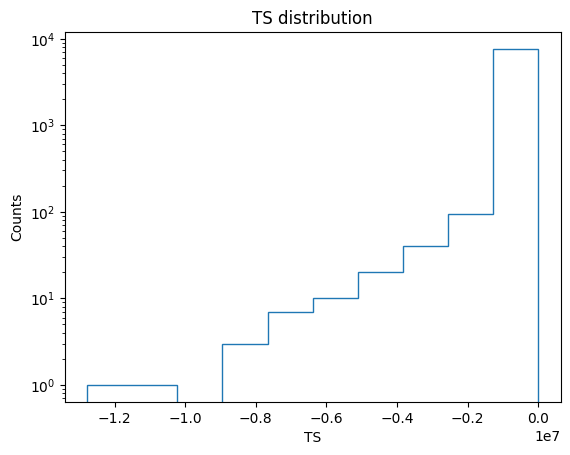

In [47]:
# for i in range(1, len(all_TSS)):
plt.figure()
histdetails = plt.hist(np.ravel(all_TSS[:]), bins=10, density=False, histtype='step')
# plt.ylim(0, 1000)
plt.yscale('log')
plt.xlabel('TS')
plt.ylabel('Counts')
plt.title('TS distribution')
plt.show()

histdetails = np.histogram(np.ravel(all_TSS[1:]), bins=10)

In [59]:
histdetails

(array([1.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 7.000e+00, 1.000e+01,
        2.000e+01, 4.000e+01, 9.300e+01, 7.598e+03]),
 array([-1.27760839e+07, -1.14984751e+07, -1.02208664e+07, -8.94325761e+06,
        -7.66564886e+06, -6.38804012e+06, -5.11043137e+06, -3.83282262e+06,
        -2.55521387e+06, -1.27760512e+06,  3.62294331e+00]),
 [<matplotlib.patches.Polygon at 0x13a1f7ee0>])

In [60]:
max(np.ravel(all_TSS[:]))

3.622943311814534

np.count_nonzero(np.ravel(all_TSS[1:])> )

In [61]:
all_TSS = np.array(all_TSS, dtype=np.float64)

In [62]:
all_TSS.shape

(2, 5, 1000)

In [63]:
for w in range(2):
    for g in range(len(gamma_arr)):
        print(min(all_TSS[w][g]), max(all_TSS[w][g]))
        # np.savetxt(f'TS_w{w}_g{g}.txt', all_TSS[w][g])
        
    print('wt\n')

with open(altier_path[0] + f'all_TSS_{len(enus)}_bins.pkl', 'wb') as f:
    pickle.dump(all_TSS, f)

-7938459.112936995 3.308401413256082
-7039081.372264593 3.622943311814534
-6931027.207299854 3.489417320886514
-7025409.178530411 3.061551798413294
-6827171.306457343 2.7886222183405565
wt

-7940011.586684313 6.36681818348595e-11
-10529382.983902585 5.5392135315897995e-11
-12776083.853687536 -5.859091012188953e-12
-7551701.681173635 -4.593709861468381e-10
-7833779.663094846 -5.720986400820554e-09
wt



### set ploting parameters $\mathrm{E}_v^2 \frac{\mathrm{dF}}{\mathrm{dE}_v}$

In [79]:
#Plotting

all_TSS = np.asarray(all_TSS)
gamma_arr = np.asarray(gamma_arr)

all_e_UL = []
e_decade = [1e13, 1e14, 1e15, 1e16, 1e17]
for e_UL in e_decade:
    e2dfde = []

    for gamma in prange(len(gamma_arr)):
        temp = []
        for phi in range(len(phio)):
            temp.append( e_UL**2 * dfde(e_UL, gamma_arr[gamma], phio[phi]))        #in eV
        e2dfde.append(temp)
    e2dfde = np.asarray(e2dfde)

    all_e_UL.append(e2dfde)
mark = ['^', 'o', 's', 'd']

In [80]:
print(len(all_e_UL))

5


In [81]:
for i in all_e_UL:
    print(i.shape)
    print('next energy bin')

(5, 1000)
next energy bin
(5, 1000)
next energy bin
(5, 1000)
next energy bin
(5, 1000)
next energy bin
(5, 1000)
next energy bin


In [82]:

all_e_UL=np.asarray(all_e_UL)

In [83]:
print(all_e_UL)

[[[1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
   9.59360829e+07 1.00000000e+08]
  [2.51188643e-10 2.61829163e-10 2.72920423e-10 ... 2.31187295e+08
   2.40980545e+08 2.51188643e+08]
  [3.38844156e-10 3.53197823e-10 3.68159521e-10 ... 3.11863080e+08
   3.25073810e+08 3.38844156e+08]
  [1.00000000e-09 1.04236067e-09 1.08651577e-09 ... 9.20373200e+08
   9.59360829e+08 1.00000000e+09]
  [3.16227766e-09 3.29623387e-09 3.43586456e-09 ... 2.91047561e+09
   3.03376532e+09 3.16227766e+09]]

 [[1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
   9.59360829e+07 1.00000000e+08]
  [1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
   9.59360829e+07 1.00000000e+08]
  [1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
   9.59360829e+07 1.00000000e+08]
  [1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
   9.59360829e+07 1.00000000e+08]
  [1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
   9.59360829e+07 1.00

In [84]:
all_TSS[1].shape

(5, 1000)

In [76]:
for w in range(1):
    for g in range(0,4):
        print(phio[np.argmax(all_TSS[w][g])])

7.3259654282152e-24
3.47168681892656e-24
2.3898925662310525e-24
4.184288507901576e-25


In [85]:
all_TSS[1][1]

array([-1.14138476e-10, -1.14144472e-10, -5.09423614e-11, -4.11510825e-11,
        5.53921353e-11, -1.34806388e-10, -7.87283572e-11,  3.89037691e-11,
       -9.93651828e-11,  1.91207050e-11, -8.01416711e-11, -1.67960312e-10,
        2.80442335e-12, -5.45294920e-11, -8.88882301e-11, -9.74729186e-11,
       -8.70807870e-11, -6.16209306e-11, -1.91529015e-11, -2.20497842e-10,
       -1.17659438e-10, -2.33064901e-10, -8.62814265e-11, -1.79085413e-10,
       -2.09459117e-10, -2.42382336e-10, -2.21742180e-10, -1.78043802e-10,
       -9.57105506e-11, -2.29708697e-10, -8.87616647e-11, -1.46018087e-10,
       -1.65033320e-10, -1.36231249e-10, -3.29112293e-10, -2.10747198e-10,
       -3.20196758e-10, -3.56033869e-10, -3.55127261e-10, -2.87521562e-10,
       -1.83566718e-10, -2.57002419e-10, -2.82200485e-10, -2.30580222e-10,
       -3.60663721e-10, -4.41005233e-10, -4.36247261e-10, -3.65470099e-10,
       -4.67271111e-10, -4.85154361e-10, -4.13093116e-10, -5.04991826e-10,
       -5.17504262e-10, -

In [91]:
tete = np.float64('2.543345761304638e-23 9.396648314954749e-24 1.4526539259467783e-24 2.3408272761782943e-23 8.296958520834915e-24 1.2305240043592616e-24 1.61141427725301e-23 5.711586478126447e-24 8.470868266557419e-25'.split(' '))

In [92]:
tete[2::3].mean()

1.1767549189872607e-24

### derived upper limits on our neutrino flux  at TS=-3.84 with interplation

In [95]:
# e2dfde = all_e_UL[1][2]
# dist_g25 = interp.interp1d(all_TSS[1][2], e2dfde/1e9)

# print(dist_g25(-3.84))

all_UL = []
for ws in range(1):
    ul_all_gamma = []
    for gamma in prange(len(gamma_arr)):
        temp = []
        for i in all_e_UL:
            #print(len(all_TSS[ws][gamma]))
            print(len(i[gamma]/1e9))
            dist_g = interp.interp1d(all_TSS[ws][gamma], i[gamma]/1e9)
            print()
            temp.append(dist_g(-3.84))

        ul_all_gamma.append(temp)
    all_UL.append(ul_all_gamma)
len(all_UL[0])

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000



5

#### IceCube measured diffused astrophysical neutrino flux

In [98]:
phio_paper = 1.68*3e-18
phio_paper_low=1.46*3e-18
phio_paper_high=1.87*3e-18 
spectral_index= -2.58
spectral_index_high=-2.49
spectral_index_low=-2.68

ic_e_paper = np.logspace(np.log10(15e12), np.log10(5e15))
print(ic_e_paper)
e2dfde_ic = 1e10 * dfde(1e14, spectral_index, phio_paper)
e2dfde_ic_low =1e10 * dfde(1e14, spectral_index, phio_paper_low)
e2dfde_ic_high=1e10 * dfde(1e14, spectral_index, phio_paper_high)
########e2dfde_ic @ 100TeV   in GeV unit###########
print(phio_paper * ((1e14/(10**14))**spectral_index))
print(e2dfde_ic)

[1.50000000e+13 1.68880140e+13 1.90136678e+13 2.14068725e+13
 2.41013042e+13 2.71348775e+13 3.05502794e+13 3.43955698e+13
 3.87248576e+13 4.35990625e+13 4.90867719e+13 5.52652061e+13
 6.22213049e+13 7.00529513e+13 7.88703481e+13 8.87975696e+13
 9.99743065e+13 1.12557833e+14 1.26725217e+14 1.42675816e+14
 1.60634078e+14 1.80852704e+14 2.03616200e+14 2.29244883e+14
 2.58099386e+14 2.90585736e+14 3.27161065e+14 3.68340043e+14
 4.14702121e+14 4.66899682e+14 5.25667224e+14 5.91831696e+14
 6.66324131e+14 7.50192750e+14 8.44617712e+14 9.50927716e+14
 1.07061871e+15 1.20537491e+15 1.35709256e+15 1.52790654e+15
 1.72022047e+15 1.93674050e+15 2.18051338e+15 2.45496936e+15
 2.76397046e+15 3.11186479e+15 3.50354775e+15 3.94453089e+15
 4.44101953e+15 5.00000000e+15]
5.039999999999999e-18
5.0399999999999995e-08


### set the  plot package

In [96]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
yellow_patch = mpatches.Patch(color='grey',alpha=0.5,edgecolor=None,linewidth=0)
blue_dotted_line = mlines.Line2D([], [], linewidth=2, linestyle='solid', color='grey')
orange_line = mlines.Line2D([], [], linewidth=2, color='orange')
firebrick_line=mlines.Line2D([], [], linewidth=2, color='firebrick')
olivedrab_line=mlines.Line2D([], [], linewidth=2, color='olivedrab')
dodgerblue_line=mlines.Line2D([], [], linewidth=2, color='dodgerblue')
magenta_line=mlines.Line2D([], [], linewidth=2, color='purple')
dashed_line=mlines.Line2D([0], [2],linestyle='--', color='k', lw=2)

### plot the  $\mathrm{E}_v^2 \frac{\mathrm{dF}}{\mathrm{dE}_v}$ vs TS


TS_vs_E2dfde_all_w_model_bins=1000000.png
DONE


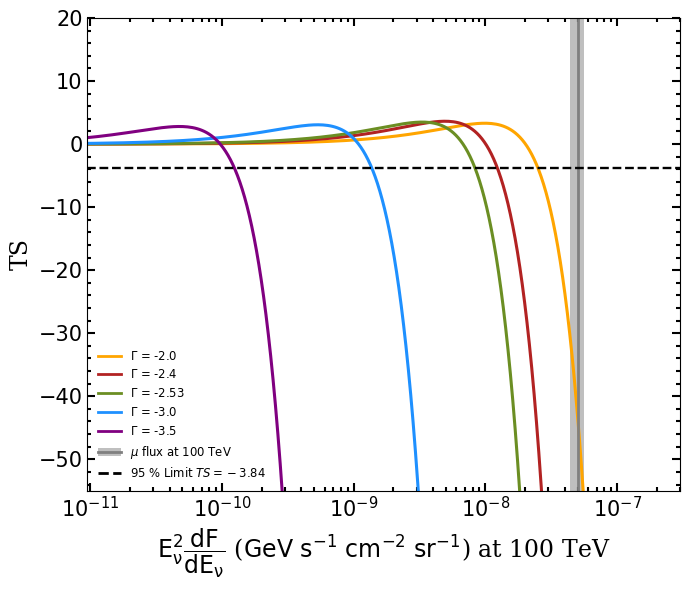

In [99]:
e2dfde = all_e_UL[1]
# plt.style.use('default')
font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 17,
        }
minor_x_array=np.logspace(-12,-6,50)
fig, axs = plt.subplots(1,1, figsize=(7, 6))
c_arr=['orange','firebrick','olivedrab','dodgerblue','purple']
# c_arr=['orange','firebrick','olivedrab','dodgerblue','magenta']
if os.path.exists(os.getcwd() + "/outputs3/stacking_TS_max2.txt"):
        os.remove(os.getcwd()+"/outputs3/stacking_TS_max2.txt")
with open(os.getcwd()+"/outputs3/stacking_TS_max2.txt","a+") as f:
        for gamma in [0, 1, 2,3,4]:#range(4):
                
        #     for i in range(1):
                # axs.plot(e2dfde[gamma]/1e9, all_TSS[0][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2,c=c_arr[gamma])# + ' with wt')    #in GeV
                axs.plot(e2dfde[gamma]/1e9, all_TSS[0][gamma],  lw=2.2,c=c_arr[gamma])# + ' with wt')    #in GeV
                all_TSS[0][gamma]=np.nan_to_num(all_TSS[0][gamma], nan=0.0)
                f.write(str(e2dfde[gamma][np.where(all_TSS[0][gamma]==np.max(all_TSS[0][gamma]))[0][0]]/1e9)+ "    "+str(np.max(all_TSS[0][gamma])) + '\n')
f.close()
        # axs.set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = 1}}$', fontdict=smallerfont)
# axs[1].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = \dfrac{1}{d_{DM}^2}}}$' , fontdict=smallerfont)
# axs[2].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = s_{1400}}}$', fontdict=smallerfont)
# axs.axvspan(e2dfde_ic_low, e2dfde_ic_high, facecolor ='grey', alpha = 0.5,linewidth=3,label='$\mu$ flux at 100 TeV(IceCube)') 
# axs.vlines(e2dfde_ic,  -55, 20, lw=2, color='grey')
axs.axvspan(e2dfde_ic_low, e2dfde_ic_high, facecolor ='grey', alpha = 0.5,linewidth=3) 
axs.vlines(e2dfde_ic,  -55, 20, lw=2, color='grey')
# for i in range(3):
    
# axs.text(1e-8,0.6,'95 % UPPER LIMIT $TS = -3.84$')    
# axs.annotate('95 % UPPER LIMIT $TS = -3.84$',xy=(0.6,0.6),xytext=(0.8,0.8), arrowprops=dict(facecolor='black',shrink=0.6,width=2))
axs.set_xlabel('$\mathsf{{E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}}}$ ($\mathsf{{GeV}}$ $\mathsf{{s^{-1}}}$ $\mathsf{{cm^{-2}}}$ $\mathsf{{sr^{-1}}}$) at 100 TeV', fontdict=axesfont)
axs.set_ylabel('TS', fontdict=axesfont)
axs.xaxis.set_tick_params(labelsize=15)
axs.yaxis.set_tick_params(labelsize=15)
axs.tick_params(which='major', width=1.5, length=6,direction='in')
axs.tick_params(which='minor', width=1.5, length=3,direction='in')
axs.set_ylim(-55, 20)
axs.set_xlim(0.95e-11, 3e-7)
#axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())
axs.tick_params(which='minor', length=3, color='k')
axs.tick_params(axis='x', which='minor', bottom=True,top=True)
axs.tick_params(axis='x', which='major', bottom=True,top=True)
axs.tick_params(axis='y', which='minor', right=True)
axs.tick_params(axis='y', which='major', right=True)
# axs.hlines(-3.84,  0.95e-11, 3e-7,linestyles='dashed', lw=1.7, ls='--', label='95 % Limit $TS = -3.84$', color='k')
axs.hlines(-3.84,  0.95e-11, 3e-7,linestyles='dashed', lw=1.7, ls='--', color='k')
axs.xaxis.set_minor_locator(FixedLocator(minor_x_array))
axs.xaxis.set_minor_formatter(NullFormatter())
#plt.suptitle('TS vs Total Neutrino Flux at 100 TeV', fontweight='bold', fontsize=16, fontfamily='serif')
# axs.legend(prop={'size':12}, framealpha=0)
axs.set_xscale('log')

plt.tight_layout()
plt.legend([orange_line, firebrick_line, olivedrab_line,dodgerblue_line,magenta_line,(yellow_patch, blue_dotted_line),\
dashed_line], ['$\Gamma$ = -2.0', '$\Gamma$ = -2.4','$\Gamma$ = -2.53','$\Gamma$ = -3.0','$\Gamma$ = -3.5',\
'$\mu$ flux at 100 TeV','95 % Limit $TS = -3.84$'],fancybox=False,edgecolor=None,frameon=False,fontsize='small')
plt.savefig(f'outputs3/fig3_1.pdf')
# plt.show()
print(f'\nTS_vs_E2dfde_all_w_model_bins={len(enus)}.png\nDONE')

#### define the differential flux of neutrinos

In [100]:
gama=list(np.random.normal(2.58,0.1,100))
Phi=list(np.random.normal(1.68,0.2,100))
all_e_UL = []
e_decade = [1e13, 1e14, 1e15, 1e16, 1e17]
x = np.logspace(13.2041, 15.41497, 50)
x=list(x)
# print(x)
e2dfde = []
e_UL_GeV=[]
def model(xm,gm,ph):
    '''
    Parameters
    ----------
    e_nu : float
        The neutrino energy in eV
    
    gamma : float
        The spectral index of the neutrino flux
    
    phi0 : float (optional)
        The normalization constant of the neutrino flux in eV^-1. The default is 1e-40.
    
    Returns
    -------
    float
        The differential flux of neutrinos
    '''
    e2dfde = []
    for e_UL in xm:
    
    # e_UL_GeV.append(e_UL*1e-9)
    # for gamma in prange(len(gamma_arr)):
    # temp = []
    # for phi in range(len(phio)):
    

        e2dfde.append(3e-18*(e_UL*1e-9)**2 * ph * ((e_UL/(10**14))**(-1*gm)))        #in eV
    # e2dfde.append(temp)
    e2dfde = np.asarray(e2dfde)
    return e2dfde      #eV^-1

    # all_e_UL.append(e2dfde)

## plot points for the IceCube measurement

In [103]:
ysample=np.asarray([model(x,gama[i],Phi[i]) for i in range(len(gama))])

In [104]:
lower=np.percentile(ysample,(100-68.26)/2,axis=0)
upper=np.percentile(ysample,(100-68.26)/2+68.26,axis=0)

In [124]:
len(lower)

50

### plot the upper limits in form of the neutrino spectra

[array(2.5066073e-08), array(2.5066073e-08), array(2.5066073e-08), array(2.5066073e-08), array(2.5066073e-08)]
[array(3.09796842e-08), array(1.23332344e-08), array(4.90994906e-09), array(1.95468593e-09), array(7.78174485e-10)]
[array(2.82695503e-08), array(8.34293578e-09), array(2.46217491e-09), array(7.2663933e-10), array(2.14446469e-10)]
[array(1.3730171e-08), array(1.3730171e-09), array(1.3730171e-10), array(1.3730171e-11), array(1.3730171e-12)]
[array(3.93116851e-09), array(1.24314464e-10), array(3.93116851e-12), array(1.24314464e-13), array(3.93116851e-15)]


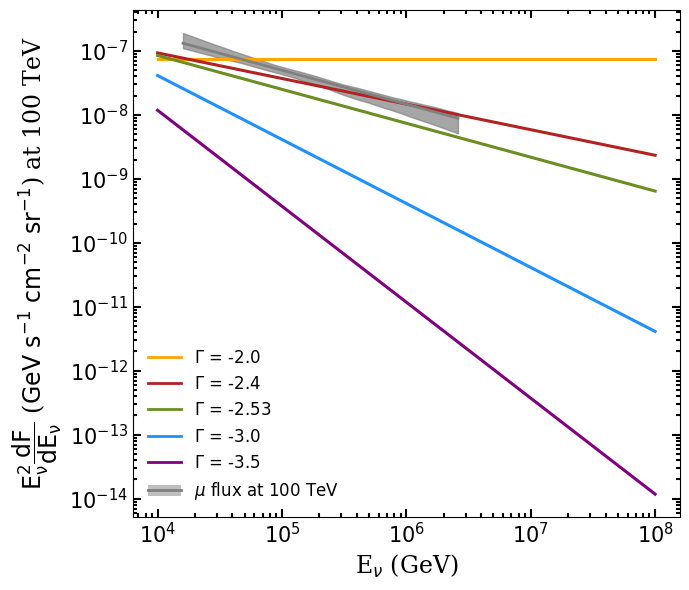

In [105]:
fig, axs = plt.subplots(1,1, figsize=(7, 6))
minor_y_array=np.logspace(-12,-6,50)
for gamma in range(0, len(gamma_arr)):

    axs.plot(np.divide(e_decade, 1e9), np.multiply(all_UL[0][gamma], 3), label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2, ls='-',c=c_arr[gamma])# + ' with wt')    #in GeV
    
    print(all_UL[0][gamma])
axs.set_xlabel('E$_{\u03BD}$ (GeV)', fontdict=axesfont)
axs.set_ylabel('$\mathsf{{E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}}}$ ($\mathsf{{GeV}}$ $\mathsf{{s^{-1}}}$ $\mathsf{{cm^{-2}}}$ $\mathsf{{sr^{-1}}}$) at 100 TeV', fontdict=axesfont)
axs.xaxis.set_tick_params(labelsize=15)
axs.yaxis.set_tick_params(labelsize=15)
axs.tick_params(which='major', width=1.5, length=6,direction='in')
axs.tick_params(which='minor', width=1.5, length=3,direction='in')

#axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())
axs.tick_params(which='minor', length=3, color='k')
# axs.set_xscale('log')
axs.tick_params(axis='x', which='minor', bottom=True,top=True)
axs.tick_params(axis='x', which='major', bottom=True,top=True)
axs.tick_params(axis='y', which='minor', right=True)
axs.tick_params(axis='y', which='major', right=True)
# axs.yaxis.set_minor_locator(FixedLocator(minor_y_array))
# axs.yaxis.set_minor_formatter(NullFormatter())
axs.legend(prop={'size':14}, framealpha=0, loc='lower left')

#x = np.linspace(e_decade[:-2][0], e_decade[1:-1][-1], 11)
# x=x*1e-9
# y = [3.9, 4.4, 10.8, 10.3, 11.2, 13.1, 14.1,  9.9, 13.9, 15.1, 12.5]

# fit a linear curve and estimate its y-values and their error.
# a, b = np.polyfit(x, y, deg=1)
# y_est = 3e-18*x*x*1.66* np.divide(x,1e5)**(-2.53)
# y_est_up =3e-18*x*x*1.91* np.divide(x,1e5)**(-2.60)
# y_est_low =3e-18*x*x*1.39* np.divide(x,1e5)**(-2.46)
# y_err = np.divide(x, 1e9).std() * np.sqrt(1/len(x) +
#                           (np.divide(x, 1e9) - np.divide(x, 1e9).mean())**2 / np.sum((np.divide(x, 1e9) - np.divide(x, 1e9).mean())**2))


axs.plot(np.divide(x,1e9), model(x,2.53,1.66), '-',c='grey',linewidth=2)

# axs.plot(x, y_est_low, '-',c='grey',linewidth=1)
# axs.plot(x, y_est_up, '-',c='grey',linewidth=1)
axs.fill_between(np.divide(x,1e9),lower, upper, color='grey',alpha=0.7,label='$\\nu$ flux(IceCube)')
# axs.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)

# axs.plot(x, y, 'o', color='tab:brown')
# axs[0].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = 1}}$', fontdict=smallerfont)
# axs[1].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = \dfrac{1}{d_{DM}^2}}}$' , fontdict=smallerfont)
# axs[2].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = s_{1400}}}$', fontdict=smallerfont)
axs.legend(prop={'size':12}, framealpha=0)

# axs.set_ylim(4e-9, 3e-7)
# axs.set_xlim(1e4, 1e8)
axs.set_xscale('log')
axs.set_yscale('log')
# plt.suptitle('95% UL of Total Energy Flux vs Neutrino Energy', fontweight='bold', fontsize=20, fontfamily='serif')
plt.tight_layout()
plt.legend([orange_line, firebrick_line, olivedrab_line,dodgerblue_line,magenta_line,(yellow_patch, blue_dotted_line)],\
    ['$\Gamma$ = -2.0', '$\Gamma$ = -2.4','$\Gamma$ = -2.53','$\Gamma$ = -3.0','$\Gamma$ = -3.5','$\mu$ flux at 100 TeV'],  fancybox=False,edgecolor=None,frameon=False,fontsize='large')
plt.savefig(f'outputs3/fig3_2.pdf')
plt.show()


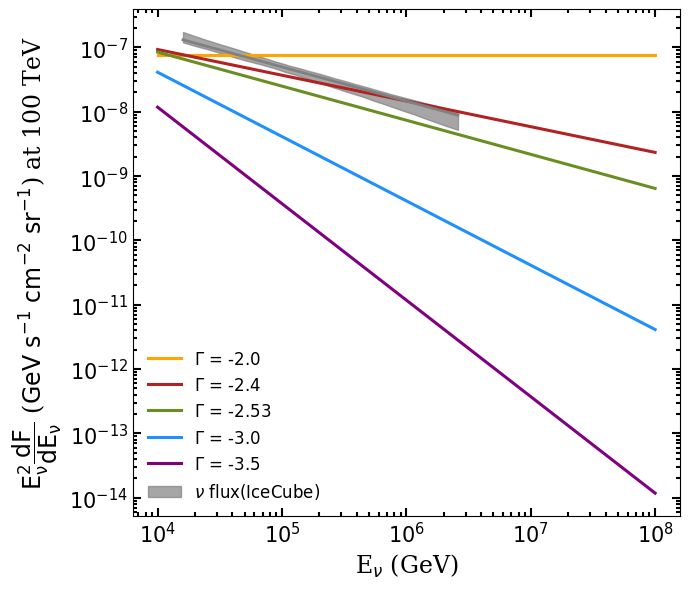

In [96]:
# fig, axs = plt.subplots(1,1, figsize=(7, 6))
# minor_y_array=np.logspace(-12,-6,50)
# for gamma in range(0, len(gamma_arr)):

#     axs.plot(np.divide(e_decade, 1e9), np.multiply(all_UL[0][gamma], 3), label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2, ls='-',c=c_arr[gamma])# + ' with wt')    #in GeV
    

# axs.set_xlabel('E$_{\u03BD}$ (GeV)', fontdict=axesfont)
# axs.set_ylabel('$\mathsf{{E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}}}$ ($\mathsf{{GeV}}$ $\mathsf{{s^{-1}}}$ $\mathsf{{cm^{-2}}}$ $\mathsf{{sr^{-1}}}$) at 100 TeV', fontdict=axesfont)
# axs.xaxis.set_tick_params(labelsize=15)
# axs.yaxis.set_tick_params(labelsize=15)
# axs.tick_params(which='major', width=1.5, length=6,direction='in')
# axs.tick_params(which='minor', width=1.5, length=3,direction='in')

# #axs.xaxis.set_minor_locator(AutoMinorLocator())
# axs.yaxis.set_minor_locator(AutoMinorLocator())
# axs.tick_params(which='minor', length=3, color='k')
# # axs.set_xscale('log')
# axs.tick_params(axis='x', which='minor', bottom=True,top=True)
# axs.tick_params(axis='x', which='major', bottom=True,top=True)
# axs.tick_params(axis='y', which='minor', right=True)
# axs.tick_params(axis='y', which='major', right=True)
# # axs.yaxis.set_minor_locator(FixedLocator(minor_y_array))
# # axs.yaxis.set_minor_formatter(NullFormatter())
# axs.legend(prop={'size':14}, framealpha=0, loc='lower left')

# #x = np.linspace(e_decade[:-2][0], e_decade[1:-1][-1], 11)
# # x=x*1e-9
# # y = [3.9, 4.4, 10.8, 10.3, 11.2, 13.1, 14.1,  9.9, 13.9, 15.1, 12.5]

# # fit a linear curve and estimate its y-values and their error.
# # a, b = np.polyfit(x, y, deg=1)
# # y_est = 3e-18*x*x*1.66* np.divide(x,1e5)**(-2.53)
# # y_est_up =3e-18*x*x*1.91* np.divide(x,1e5)**(-2.60)
# # y_est_low =3e-18*x*x*1.39* np.divide(x,1e5)**(-2.46)
# # y_err = np.divide(x, 1e9).std() * np.sqrt(1/len(x) +
# #                           (np.divide(x, 1e9) - np.divide(x, 1e9).mean())**2 / np.sum((np.divide(x, 1e9) - np.divide(x, 1e9).mean())**2))


# axs.plot(np.divide(x,1e9), model(x,2.53,1.66), '-',c='grey',linewidth=2)

# # axs.plot(x, y_est_low, '-',c='grey',linewidth=1)
# # axs.plot(x, y_est_up, '-',c='grey',linewidth=1)
# axs.fill_between(np.divide(x,1e9),lower, upper, color='grey',alpha=0.7,label='$\\nu$ flux(IceCube)')
# # axs.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)

# # axs.plot(x, y, 'o', color='tab:brown')
# # axs[0].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = 1}}$', fontdict=smallerfont)
# # axs[1].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = \dfrac{1}{d_{DM}^2}}}$' , fontdict=smallerfont)
# # axs[2].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = s_{1400}}}$', fontdict=smallerfont)
# axs.legend(prop={'size':12}, framealpha=0)

# # axs.set_ylim(4e-9, 3e-7)
# # axs.set_xlim(1e4, 1e8)
# axs.set_xscale('log')
# axs.set_yscale('log')
# # plt.suptitle('95% UL of Total Energy Flux vs Neutrino Energy', fontweight='bold', fontsize=20, fontfamily='serif')
# plt.tight_layout()
# plt.savefig(f'outputs1/UL_all_w_model_binskm2a={len(enus)}.pdf')
# plt.show()


In [291]:
np.divide(e_decade, 1e9)*np.divide(e_decade, 1e9)*1.66*np.divide(e_decade,1e14)**-2.53

array([5.62481299e+10, 1.66000000e+10, 4.89900732e+09, 1.44579956e+09,
       4.26685700e+08])

In [294]:
# e2dfde = all_e_UL[1]
# plttitles = ['$w_{acc}$ and $w_{model} = 1$', '$w_{acc}$ and $w_{model} = \dfrac{1}{d_{DM}^2}$', '$w_{acc}$ and $w_{model} =  w_{s1400}$']

#         # print(st.t.interval(0.95, len(all_TSS[i][j])-1, loc=np.mean(all_TSS[i][j]), scale=st.sem(all_TSS[i][j])))
# for i in range(1, 4):
#     plt.figure(figsize=(8, 6))
#     for j in range(1, len(gamma_arr)):
#         plt.plot(e2dfde[j]/1e9, all_TSS[i][j], label='$\Gamma$ = ' + str(gamma_arr[j]), lw=0.8)
#         # ci = st.t.interval(0.95, len(all_TSS[i][j])-1, loc=np.mean(all_TSS[i][j]), scale=st.sem(all_TSS[i][j]))
#         # plt.hlines(ci, 1e-19, 1e-6, colors='k', linestyles='dashed', lw=0.5, ls='-.', label="95% CI "+ '$\Gamma$ = ' + str(gamma_arr[j]))

#     plt.hlines(-3.84, 1e-19, 1e-6, linestyles='dashed', lw=0.7, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$')
#     # plt.vlines(dist_g25(-3.84), -120, 50, linestyles='dashed', lw=0.5, ls='-.')
#     plt.legend()
#     plt.xscale('log')
#     # plt.yscale('log')
#     plt.xlabel("$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)")
#     plt.ylabel(r'$TS$')
#     plt.ylim(-200, 50)
#     plt.title("TS vs Total Neutrino Flux at 100 TeV\nWeighting scheme: " + plttitles[i-1])
#     plt.savefig(os.getcwd() + f'/outputs/TSvsE2dFdE_ws_{i}.png', facecolor='w')
#     plt.show()

#### save the  95\% upper limits into text files.

In [107]:
with open (os.getcwd()+'/outputs3/UL_values2.txt', 'a+') as f:
    for i in range(len(gamma_arr)):
        f.write(str(gamma_arr[i])+' '+str(all_UL[0][i][1])+'\n')
f.close()    

In [108]:
data=np.loadtxt(os.getcwd()+'/outputs3/UL_values2.txt',usecols=1,unpack=True)

### average flux calculation

In [110]:
print(np.average(data))

9.447914953722642e-09
